In [1]:
import os
from collections import Counter
from pprint import pprint

import gensim
import gensim.corpora as corpora
import nltk
import numpy as np
import pandas as pd
import spacy
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from nltk.corpus import PlaintextCorpusReader, stopwords
from nltk.tag import pos_tag
import pandas as pd
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

nlp = spacy.load("en_core_web_sm")

mallet_path = os.environ['MALLET_BINARY_PATH']
mallet_path=mallet_path + '\mallet'

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                
                topic_keywords = ", ".join([word for word, prop in wp])
                
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), 
                                                                  round(prop_topic,4), 
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


def get_model_coherence(corpus, num_topics, id2word, data):
        print("Creating LdaMallet model for num_topics: " + str(num_topics))
        reviews_mallet_x = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus1, num_topics=num_topics, id2word=id2word, random_seed=1001)
        coherencemodel = CoherenceModel(model=reviews_mallet_x, texts=data, dictionary=id2word, coherence='c_v')
        coherence = coherencemodel.get_coherence()
        print("#Topics: " + str(num_topics) + " Score: " + str(coherence))
        return (reviews_mallet_x,coherence,num_topics)
    
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = stopwords.words('english')
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['time','way','thing','man','much','many','something','watch',
                'year','show','see','first','woman','end','nothing','lot','guy','day','girl','minute','look',
                'last','anything','kind','reason','least','child','anyone','friend','tv','sure','course','job',
                'someone','bit','true','everything','right','people','wife','victoria','scene','voice','version',
                'car','line','fact','city','mind','style','house','world','idea']
    summarizer.null_words = stop_words
    summarizer._cue_weight=1
    summarizer._key_weight=0
    summarizer._location_weight=0
    summarizer._title_weight=0
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

def print_summary(summary):
    for sentence in summary:
        print(sentence)
     

In [2]:
#Read in corpus and tokenization
corpus = PlaintextCorpusReader('30reviewsCom', '.+\.txt')
fids = corpus.fileids()
docs1 = []
for fid in fids:
    doc_raw = corpus.raw(fid)
    docs1.append(doc_raw)

In [3]:
#Sentence to words
data_words = list(sent_to_words(docs1))

In [4]:
#Stop word removal
stop_words = stopwords.words('english')
data_words_nostops = remove_stopwords(data_words)

In [5]:
#Create bigrams
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=10,scoring='default') # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_words_bigrams = make_bigrams(data_words_nostops)
print(data_words_bigrams[0])

['really', 'spoilers', 'opinion', 'wanted', 'cover', 'nevertheless', 'executive_producer', 'morgan_freeman', 'wants', 'audience', 'ignore', 'numerous', 'absurdities', 'character', 'items', 'less', 'movie', 'intentional', 'indie', 'feel', 'absorbed', 'mentor', 'theme', 'plays', 'alternate', 'universe', 'semi', 'washed', 'version', 'real', 'morgan_freeman', 'chauffeured', 'old', 'econovan', 'kid', 'way', 'carson', 'ca', 'brentwood', 'research', 'next', 'movie', 'role', 'carson', 'mystery', 'cal', 'residents', 'could', 'saved', 'trip', 'gone', 'anywhere', 'san', 'fernando', 'valley', 'found', 'elements', 'paz_vega', 'pretty', 'watch', 'cross', 'salma', 'hayek', 'penelope_cruz', 'playing', 'disgruntled', 'grocery', 'checker', 'large', 'slow', 'local', 'market', 'apparently', 'ultimate', 'source', 'moragn', 'freeman', 'research', 'character', 'known', 'allude', 'actors', 'regarded', 'encountered', 'real_life', 'average', 'people', 'psst', 'etc', 'unfortunately', 'distracted', 'kinds', 'worl

In [9]:
#POS Tagging - only nouns
print("Started PoS tagging")
noun = [[w for w , pos in pos_tag(doc) 
        if (pos=='NN' or pos=='NNS' or pos=='NNP' or pos=='NNPS')] 
        for doc in data_words_bigrams]
print("Ended PoS tagging")

Started PoS tagging
Ended PoS tagging


In [10]:
# Do lemmatization keeping only noun
print ("Started Lemmatization")
data_lemmatized = lemmatization(noun, allowed_postags=['NOUN'])
print ("Ended Lemmatization")
print(data_lemmatized[0])

Started Lemmatization
Ended Lemmatization
['spoiler', 'opinion', 'cover', 'morgan_freeman', 'audience', 'absurdity', 'item', 'indie', 'theme', 'play', 'semi', 'version', 'morgan_freeman', 'econovan', 'way', 'carson', 'research', 'movie', 'role', 'carson', 'mystery', 'resident', 'valley', 'element', 'cross', 'salma', 'hayek', 'penelope_cruz', 'grocery', 'checker', 'market', 'source', 'moragn', 'freeman', 'research', 'character', 'actor', 'people', 'advice', 'home', 'brentwood', 'cash', 'debit', 'card', 'wisdom', 'cell_phone', 'opinion', 'everything', 'blackberry', 'display', 'intelligence', 'survival', 'nothing', 'movie', 'main_character', 'encounter', 'flirt', 'idea', 'fizzle', 'steve_martin', 'shopgirl', 'affair', 'freeman', 'audience', 'actor', 'morgan_freeman', 'four_year', 'project', 'cousin', 'director', 'drop', 'neighborhood', 'carlson', 'research', 'work', 'manager', 'supermarket', 'cashier', 'paz_vega', 'ability', 'driver', 'actor', 'position', 'secretary', 'construction', 'com

In [11]:
#Find most frequent words
flat_list = []
for sublist in data_lemmatized:
        for item in sublist:
                flat_list.append(item)

counts = Counter(flat_list)
countsDf = pd.DataFrame(list(counts.most_common()), columns= ["words", "count"], index=np.arange(0,len(counts),1))
countsDf.to_csv("wordFreq.csv", columns=countsDf.columns, index=False, encoding='utf8')
counts.most_common(50)

[('movie', 13881),
 ('film', 13710),
 ('story', 3897),
 ('character', 3652),
 ('time', 3631),
 ('people', 2648),
 ('way', 2486),
 ('scene', 2392),
 ('thing', 2189),
 ('life', 2131),
 ('man', 1973),
 ('actor', 1766),
 ('performance', 1563),
 ('part', 1456),
 ('something', 1326),
 ('director', 1260),
 ('plot', 1233),
 ('year', 1191),
 ('woman', 1174),
 ('role', 1139),
 ('world', 1119),
 ('family', 1093),
 ('lot', 1005),
 ('day', 968),
 ('comedy', 931),
 ('action', 930),
 ('nothing', 927),
 ('fact', 914),
 ('work', 875),
 ('moment', 847),
 ('book', 830),
 ('music', 827),
 ('point', 808),
 ('watch', 807),
 ('fan', 761),
 ('guy', 753),
 ('audience', 736),
 ('end', 719),
 ('girl', 719),
 ('everyone', 697),
 ('horror', 688),
 ('friend', 687),
 ('anything', 686),
 ('anyone', 680),
 ('version', 670),
 ('everything', 669),
 ('line', 669),
 ('child', 667),
 ('course', 650),
 ('house', 649)]

In [12]:
# Remove additional stopwords
stop_words = stopwords.words('english')
stop_words.extend(['time','way','thing','man','much','many','something','watch',
                'year','show','see','first','woman','end','nothing','lot','guy','day','girl','minute','look',
                'last','anything','kind','reason','least','child','anyone','friend','tv','sure','course','job',
                'someone','bit','true','everything','right','people','wife','victoria','scene','voice','version',
                'car','line','fact','city','mind','style','house','world','idea'])
data_words_nostops1 = remove_stopwords(data_lemmatized)
print("Final Stop words list created...")

Final Stop words list created...


In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_nostops1)
#print([id2word[id] for id in range(0,len(id2word))])

# Create Corpus
texts = data_words_nostops1

# Bag of words
corpus1 = [id2word.doc2bow(text) for text in texts]

In [14]:
#LDA Model
reviews_mallet = gensim.models.wrappers.ldamallet.LdaMallet(mallet_path, corpus=corpus1, num_topics=6, id2word=id2word, random_seed=1001)

result = (reviews_mallet.show_topics(num_topics=6, num_words=10,formatted=False))

for i in range(0, 6):
        pprint(result[i])

(0,
 [('movie', 0.08815442614586581),
  ('comedy', 0.026389636894469798),
  ('character', 0.023555089429972503),
  ('family', 0.014172737322486466),
  ('actor', 0.011366535332634145),
  ('life', 0.008985515462456418),
  ('humor', 0.008787097139941608),
  ('fan', 0.008021769324527339),
  ('season', 0.007880041951302475),
  ('joke', 0.007823351002012528)])
(1,
 [('film', 0.06571357430385526),
  ('story', 0.03380088807735403),
  ('movie', 0.030895962152965098),
  ('life', 0.024380628293978503),
  ('performance', 0.017388056604556584),
  ('character', 0.016765572477901815),
  ('family', 0.012179939411545005),
  ('role', 0.010436983856911648),
  ('actor', 0.01027098808980371),
  ('book', 0.009897497613810848)])
(2,
 [('movie', 0.06314708901598474),
  ('film', 0.05918756415896759),
  ('character', 0.027833993254142837),
  ('story', 0.020765508139023316),
  ('action', 0.012846458424989002),
  ('plot', 0.011673265874761696),
  ('disney', 0.010265434814488928),
  ('music', 0.00985481742190937),

In [19]:
#Compute coherence for different number of topics
coherence_values = ()
model_list = []
coherence = []

for num_topics in range(2, 9, 1):
       coherence_values = get_model_coherence(corpus1,num_topics,id2word,data_words_nostops1)
       model_list.append(coherence_values[0])
       coherence.append(coherence_values[1])

Creating LdaMallet model for num_topics: 2
#Topics: 2 Score: 0.25821813516557535
Creating LdaMallet model for num_topics: 3
#Topics: 3 Score: 0.29262966732037465
Creating LdaMallet model for num_topics: 4
#Topics: 4 Score: 0.2711742920775136
Creating LdaMallet model for num_topics: 5
#Topics: 5 Score: 0.28136171297327284
Creating LdaMallet model for num_topics: 6
#Topics: 6 Score: 0.2922126306359292
Creating LdaMallet model for num_topics: 7
#Topics: 7 Score: 0.29163738504117415
Creating LdaMallet model for num_topics: 8
#Topics: 8 Score: 0.29073562443571954


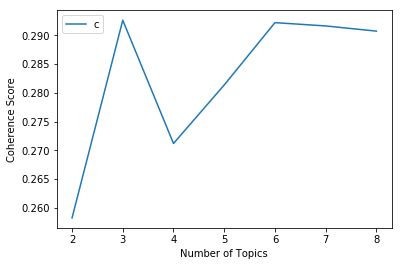

In [36]:
#Plot Number of topics vs. Coherence score
limit=9; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence"), loc='best')
plt.show()

In [20]:
#Find dominant topic per review
df_topic_sents_keywords = format_topics_sentences(ldamodel = model_list[4], 
                                          corpus = corpus1, 
                                          data = data_words_nostops1)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# export as csv
pd.DataFrame(df_dominant_topic).to_csv("df_dominant_topic_30reviewsCom.csv")


In [21]:
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.4684,"movie, film, horror, director, character, plot...","[spoiler, opinion, cover, morgan_freeman, audi..."
1,1,4.0,0.3835,"movie, film, horror, director, character, plot...","[movie, indie, film, play, script, morgan_free..."
2,2,5.0,0.5161,"film, movie, story, life, performance, war, pa...","[movie, american, somebody, tower, director, o..."
3,3,5.0,0.6373,"film, movie, story, life, performance, war, pa...","[film, care, detail, policy, american, directo..."
4,4,0.0,0.1667,"movie, comedy, character, family, actor, life,...",[]
5,5,5.0,0.6822,"film, movie, story, life, performance, war, pa...","[film, medium, outlet, outlet, film, rookie, n..."
6,6,0.0,0.1667,"movie, comedy, character, family, actor, life,...",[]
7,7,2.0,0.4034,"movie, film, character, story, action, plot, d...","[movie, reference, max, many_other, reference,..."
8,8,1.0,0.2601,"film, story, movie, life, performance, charact...","[christmas_carol, movie, story, movie, rest, s..."
9,9,1.0,0.6054,"film, story, movie, life, performance, charact...","[story, three_spirit, ghost, highlight, part, ..."


In [22]:
#Code to save the model
reviews_lda_mallet=model_list[4]

reviews_lda_mallet.save("reviews_lda_mallet")

lda_disk=gensim.models.wrappers.LdaMallet.load("reviews_lda_mallet")

In [23]:
#Check saved model
pprint(lda_disk.show_topics())

[(0,
  '0.088*"movie" + 0.026*"comedy" + 0.024*"character" + 0.014*"family" + '
  '0.011*"actor" + 0.009*"life" + 0.009*"humor" + 0.008*"fan" + 0.008*"season" '
  '+ 0.008*"joke"'),
 (1,
  '0.066*"film" + 0.034*"story" + 0.031*"movie" + 0.024*"life" + '
  '0.017*"performance" + 0.017*"character" + 0.012*"family" + 0.010*"role" + '
  '0.010*"actor" + 0.010*"book"'),
 (2,
  '0.063*"movie" + 0.059*"film" + 0.028*"character" + 0.021*"story" + '
  '0.013*"action" + 0.012*"plot" + 0.010*"disney" + 0.010*"music" + '
  '0.009*"kid" + 0.009*"animation"'),
 (3,
  '0.059*"film" + 0.048*"movie" + 0.017*"story" + 0.013*"series" + '
  '0.011*"effect" + 0.010*"book" + 0.010*"zombie" + 0.008*"character" + '
  '0.006*"special_effect" + 0.006*"fan"'),
 (4,
  '0.109*"movie" + 0.075*"film" + 0.015*"horror" + 0.013*"director" + '
  '0.012*"character" + 0.012*"plot" + 0.008*"actor" + 0.008*"killer" + '
  '0.008*"money" + 0.008*"story"'),
 (5,
  '0.073*"film" + 0.015*"movie" + 0.015*"story" + 0.012*"life" + 

In [26]:
# Visualize the topics
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(reviews_lda_mallet)
vis = pyLDAvis.gensim.prepare(model, corpus1, id2word)
vis
pyLDAvis.save_html(vis, 'lda.html')

C:\apps\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\apps\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\apps\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\apps\miniconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [35]:
#Save theta
mixture = [dict(reviews_lda_mallet[x]) for x in corpus1]
pd.DataFrame(mixture).to_csv("doc_topic_mixture.csv")

In [30]:
#Extract topic words as a list
bonus_words = [text.split(', ') for text in df_dominant_topic['Keywords'].tolist()]
print(bonus_words[0:10])

[['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story'], ['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story'], ['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history'], ['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history'], ['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke'], ['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history'], ['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke'], ['movie', 'film', 'character', 'story', 'action', 'plot', 'disney', 'music', 'kid', 'animation'], ['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book'], ['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book']]


In [34]:
#Generate summary from corpus's raw text using bonus(topic) words
list = []
doc = 0

for fid in fids:
    # extract filename
    fname = os.path.splitext(fid)[0]
    print(fname)
    # extract raw text
    doc_raw = corpus.raw(fid)
    # extract lda keywords for each doc
    words = bonus_words[doc]
    # split up bigrams used in LDA model
    words = [item for sublist in [item.split('_') for item in words] for item in sublist]
    print(words)
    # summarize and print summary below
    sentence_count = 5
    print_summary(summarize(doc_raw, sentence_count, words))
    print()
    # update doc count
    doc += 1
    
#output as dataframe
df = pd.DataFrame(data = list, columns = ['movie_pos_neg', 'reviews_summary'])

#export df to csv
pd.DataFrame(df).to_csv("30reviewsCom_summary.csv")


30reviewsCom/10 Items or Less(2006)_negative
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
As the executive producer, Morgan Freeman wants the audience to ignore the numerous absurdities of his character in 10 Items Or Less, a movie with an intentional indie-feel, and just be absorbed in the mentor/be-all-that-you-can-be theme.
His character is only known as "Him" to allude to how actors are regarded when encountered in real life by average people-"Psst, that's 'him,' etc.
Instead of characters that were pensive and introspective as in Translation, we get characters that spew pointless advice on topics they have no clue about.
The dialogue makes the characters cheesy and unsympathetic with the exception that I felt sorry for both of the actors for having signed onto this project.
You're not saying we have him play a big-name actor that's doing a low-budget movie, are you?Writer: Why not?Producer: That's ridiculous!

30reviewsCom/10 It

['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book']
Perhaps Cyd Charisse, who was originally intended for the role could have done better, however Caron is quite believable in the role and has chemistry with Kelly.
While the story is sweet, and the dancing and singing in the main part of the film are a joy, the uniqueness of the film (and what makes it a masterpiece) is the dream sequence.
When Vincente Minnelli decided to make a Gershwin "panorama" film, he wanted Kelly's character to be more sophisticated than the "goody two shoes" roles he had been playing in most his films (with the exception of "For Me and My Gal").
In my opinion, the WB film "Pal Joey" is a wreck, though Sinatra was suitable for the role, but other problems sunk the film (script changes and poor direction.
It won the Oscars for Best Art Direction-Set Decoration, Best Cinematography, Best Costume Design, Best Music, Scoring of a Musical Picture, Best Writing, Story and

It was filmed with sequences of animation and the actors and actresses interacting with the animations.
I was lucky enough to catch this film finally on Turner Classic films tonight, as it is one of the films that won an Oscar (for special effects) in their yearly month of Oscar winning films.
The animation resembles very much that of the 1973 animated film "Robin Hood" and the same can be said about the animated characters: there are plenty of wild animals such as bears, elephants, hippos, lions, crocodiles and others like in "Robin Hood".
This movie has always been my favorit Disney movie.
Brilliantly inventive, with loads of laughs, this movie will delight kids of all ages with its great characters, exciting story and catchy tunes.

30reviewsCom/Before Sunrise(1995)_negative
['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke']

30reviewsCom/Before Sunrise(1995)_positive
['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 

The special effects, dialogue and acting were all spot on, and I felt emotionally tied up in the storyline.
Just as the new BSG wasn't what fans of the original series were expecting, Caprica may not deliver what fans of the new BSG were expecting (for the most part).

30reviewsCom/Che - Part Two(2008)_negative
['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history']
All these overrated "artists" have often indulging themselves in similar, politically one-sided projects, yet somehow Che Guevara, who is arguably the most popular and well-known Communist, hasn't been a film topic of theirs yet.
The movie is to the most part extremely slow (no surprise there), and visually uninteresting.
Even a director as brilliant as Kubrick would have carefully considered releasing a movie that goes beyond the 3-hour mark, so it's quite telling that this Soderbergh, who has only made one or two solid movies and early on in his career, would think that His Oceanic 

This killer didn't mess around, and I loved it, and Slasher fans(like myself) should really enjoy this film, plus The opening was really wicked too, with them filming the movie!.

30reviewsCom/Cypher(2002)_negative
['film', 'movie', 'story', 'series', 'effect', 'book', 'zombie', 'character', 'special', 'effect', 'fan']
Somewhere inside this movie is a half-hour episode from The Twilight Zone trying to get out.
None of the characters spark off each other, and for a film made in 2002 the technology is truly cheesy.
It is difficult to connect this tired and uninspired movie with the director of Cube.
It's not a bad movie, but it is most definitely not a good one.
Before I knew it, the film was over and the story never picked up.

30reviewsCom/Cypher(2002)_positive
['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history']
This movie appeals to me who loved War Games, Sneakers, and Track Down.
If you came into the film with expectations, throw them away

30reviewsCom/Edison(2005)_negative
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
(In a movie there is usually a good start to catch audience,done, a bit boring yet story filling middle of the movie that is more about characters and less about action ,done, and the third part is something really good so that you can remember the movie.
i knew we were in trouble when before the film the director was talking about how when he was directing an episode of wiseguy he met an unknown actor named kevin spacey (a director/writer of wiseguy making his feature debut = blah).
Justin Timberlake is perhaps the single worst actor to land a bigtime role in a movie with the star power and money behind it that Edison had.
The story was OK and all the other characters were played by professional actors, heck, even LL Cool J was fine since he has had numerous small parts to cut his teeth on.
Both of these great actors probably signed on to the movie think

30reviewsCom/Forbidden Planet(1956)_positive
['film', 'movie', 'story', 'series', 'effect', 'book', 'zombie', 'character', 'special', 'effect', 'fan']
The film drew raves when it was released, for its Oscar nominated special effects, its all electronic music score, by Louis and Bebe Barron (although credited as Electronic Tonalities, to avoid music guild fees), vivid matte paintings- inspired by Chesley Bonestell, and the famed Monster Of The Id (MOTI), which was animated by an animator, Joshua Meador, on loan from the Walt Disney studio.
I like movies where the writers have clearly credited their audiences with a modicum of intelligence, unlike most modern blockbusters which spend $150m on special effects, but about $1.
This is a classic of that very special sub-genre of sci fi I like to call 1950s sci-fi, and, though not, in my opinion, the best it is certainly a must see for anybody interested in sci-fi film and special effects.
You can nitpick and say the planet is obviously filmed

Devil's Experiment is a short film with no story, no character development.

30reviewsCom/Gunga Din(1939)_negative
['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history']
This movie is rated a classic on sentiment not on any quality of movie-making.
It moves from the unlikely to the unbelievable, from the unrealistic to the ludicrous.
The unbelievable plot revolves around an attempt by two British soldiers and a Hindu gofer to rescue a third soldier who has been captured by insurgent Indians.
In the British army, a sergeant does not order up a rescue attempt, and if you get past that, he does not attempt it with only one other soldier and an Indian servant when there is a full regiment on hand.
The Indian insurgents are so incredibly inept it is laughable.

30reviewsCom/Gunga Din(1939)_positive
['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history']
Yet another underrated element in the film is Eduardo Cian

From an adult viewpoint the film has a number of faults; it can be sentimental, some of the incidents (such as the one in which the animals manage to catapult a mountain lion into the river) are quite incredible, and the human characters are all completely forgettable.

30reviewsCom/House of Games(1987)_negative
['film', 'movie', 'story', 'life', 'performance', 'war', 'part', 'event', 'country', 'history']
This movie had potential, but what makes it really bad is Lindsay Crouse's acting.
The first part of the script has the makings of a good movie.
That was so staged that it felt like slap in the face to even half-witted movie viewers.
While the film has elements of early film noir (except that it is in color) the approach is so exaggerated that I almost have to conclude that it is a parody of the genre.
I don't feel like going into details, but at the end of the film it is revealed that the events of the whole movie were an elaborate con by Mike and his cronies to swindle Margaret out

It however is an eternal shame that the movie is lacking in its story telling and style, or else this movie could had been a real classic in its genre.

30reviewsCom/Kalifornia(1993)_negative
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
Another movie to suffer without an adventure to run, no enigma to solve.
Pitt and Lewis are great actors; magnificent Michelle Forbes but a weak David Duchovny performance.
He's on autopilot for the whole film.
I was expecting to love this movie--film noir, serial killer, dark irony.
even Matthew Mc Conahay *however you spell it* was better then all the actors in this movie, when he played a psycho in Texas Chainsaw 4.

30reviewsCom/Kalifornia(1993)_positive
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
Duchovony is aptly geeky and naive, and Forbes seems emphatically cynical and shut-off, but both actors manage to convincingly portray their characte

But that never happens in the movie.
Daniel-Day Lewis is a good actor, but not as good as some reviewers here would have us believe.
I tought he repeated the same set of 4 or 5 movements in the movie.

30reviewsCom/My Left Foot(1989)_positive
['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book']
To me those two performances are two of the best ever film performances,especially Daniel day-Lewis's performance which I would regard as high as Antony Hopkins in the silence of the lambs.
Richly detailed story of a family that stayed together under the most unusual of circumstances with attention to period detail in every frame of the film.
When he finished writing that one word, we all knew that we had witnessed not one but three triumphs - the triumph of a human will and spirit, the triumph of the cinema which was able to capture the moment like this on the film, and the triumph of an actor who did not act but who became his character.
Daniel Day-

30reviewsCom/Over Her Dead Body(2008)_positive
['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke']
The jokes in this film were surprisingly original and really funny with one or two flat jokes in between.
The staple ingredients of a good film are all there; script, director and actors and compared some other recent attempts at romantic comedy, this film stands tall.
This movie exposes popular, but otherwise hackneyed, movies like "Ghost" for the mediocre and overly sentimental crap fests they are.
The other characters are stereotypes and the plot is formulaic (I mean we are not talking 'Apocalypse Now' here) But the characters are likable, the story is engaging, the soundtrack, production and direction all work well.
overall i liked the movie only because it had a good amount of laughs to keep me going otherwise i would have given this movie a lower rating.

30reviewsCom/Panic in the Streets(1950)_negative
['movie', 'comedy', 'character', 'fami

30reviewsCom/Purple Rain(1984)_negative
['movie', 'film', 'character', 'story', 'action', 'plot', 'disney', 'music', 'kid', 'animation']
By the numbers story of the Kid (Prince), a singer, on his way to becoming a star.
I was no big fan of Prince but I did like the three big songs from this movie--"Purple Rain", "Let's Get Crazy", and "When Doves Cry".
Unfortunately that's a VERY small portion of the movie.
Even the score is mesmerising, and if this was shot purely as a concert film it would be a great experience unfortunately it's not and as such the movie has some problems.
Prince and Morris's lives seemingly take a back seat to the performances here, which I guess makes sense from a business perspective, but it's exhausting to have a 2 hour movie where seemingly half of it takes place on stage, especially when the character's back stories get pushed aside for it.

30reviewsCom/Purple Rain(1984)_positive
['movie', 'film', 'character', 'story', 'action', 'plot', 'disney', 'music', 'ki

Most crappy movies have their moments, (even Godzilla had a few cool special effects) this film's moment was when I left the theater nauseated.
Please avoid this movie at all costs.
I was wondering why the hell Springer has millions of fans, yet none of them checked out his movie.

30reviewsCom/Ringmaster(1998)_positive
['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke']
Just saw the movie, and the scary thing was, the people talking during the movie sounded just like the actors.
The movie had its moments, but also lagged and was rather sick.
WARNING- Jerry takes his shirt off during the movie!!
This movie is one of those that is so bad, it's good!
Again, I give this movie a seven.

30reviewsCom/Road to Perdition(2002)_negative
['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book']
Maybe because I'm such a fan of the graphic novel and at the risk of sounding like a fanboy(the only form of life lower th

The acting is wonderful - though none of us in the west are likely to have heard of these actors, we should have long ago - they play their characters with honesty and reverence - these are flawed characters, each with major weaknesses, but with such utter humanity and kindness that it's impossible not to become engaged in the story.
The actors are enormous, especially the one who performs the role of the retarded boy; and Yang Zhang makes a good job, easy, simple, letting the story just flow by itself.
It has a wonderful chemistry between the actors and tells a story that is pretty universal, the story of the prodigal son.
No, definitely not the perfect little life so often depicted in the totally artificial Hollywood movies but rather, the real life complete with real characters each with strengths and weaknesses just like real people in our lives and ourselves.
The two main themes of the movie, the family and the problems of progress, are incredibly well handled, and the movie never

Sudden Impact is the 4th of the Dirty Harry films and one of the best traits of these films is that they don't really degrade in quality from one film to the next.
However, what makes it slightly inferior to the better movies of Eastwood is that though the character of the lead role is captivating the plot is not, as it is far too obvious from the beginning.

30reviewsCom/Surviving Christmas(2004)_negative
['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke']
As with most of Ben Affleck's movies, the comedy is dry and story is predictable.
Dumped by his girlfriend, a hotshot yuppie doesn't want to be left alone on Christmas so he decides to return to his boyhood home, imposing on the dysfunctional family that now lives there and bribes them to pose as his family.
An obnoxious and one-dimensional performance by Affleck, who mainly acts with a flashy smile, makes his character come off as a mentally unbalanced creep, but Gandolfini and O' Hara brea

In pondering the reason for existence of Downey's character's significant screen-time in the movie, I decided that either the director had liked his character and unnecessarily increased his screen-time (unlikley, as the director didn't change anything else about the script he actually needed to) or that his character was going to be sacrificed on the altar of bad plotting.
The plot is unrealistically convoluted, the actors sport bad accents and director Robert Altman's participation amounts to collecting a pay check.
this was the most pointless film i have ever seen as there was no plot and the actors did not seem to care.

30reviewsCom/The Gingerbread Man(1998)_positive
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
7 rating on this film.
The plot is fairly standard but effectively executed.
The biggest surprise in this movie was the performance of Daryl Hannah.
Rather than playing the stereotypical ditzy blonde roles that she usuall

Just like Tom Stoppard's beguiling film, we get to view the action from the point of view of two of the minor characters from the original: Timon, the meerkat with a penchant for breaking into song at the drop of a hat, and Pumbaa, the warthog with flatulence issues.

30reviewsCom/The Lord of the Rings(1978)_negative
['film', 'movie', 'story', 'series', 'effect', 'book', 'zombie', 'character', 'special', 'effect', 'fan']
Now I realize that any attempt to convert a book into a movie is bound to fail in many ways, simply because of the medium, but this movie, regardless of the source of the story, is just plain pathetic.
None of the characters had any emotions when they were talking and they seemed to be reading it of a page, even my favourite character who is Gandalf did not seem interesting at all.
I just hope that nobody judges the books by this film.
all I will say is that the movie (for me, anyway) lost major points for turning my favorite character, Sam, into a bumbling idiot.
Ther

No, the film did not investigate both "sides" of the story, but then surely one film in favour of Chavez against the tides of propaganda against him should be seen as an attempt to balance out the narrative overall (especially given A. the history of CIA involvement in Latin America in fermenting civil unrest - google National Security Archive and B. the coverage in that country and elsewhere of the clearly faked scenes of Chavez supporters shooting non-existent opponents).

30reviewsCom/The Rookie(2002)_negative
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
I'm sorry, I had high hopes for this movie.
Unfortunately, it was too long, too thin and too weak to hold my attention.
When I realized the whole movie was indeed only about an older guy reliving his dream, I felt cheated.
So, don't buy a large drink or you'll be running to the rest room.
My kids didn't enjoy it either.

30reviewsCom/The Rookie(2002)_positive
['movie', 'comedy', '

Like the Arabian Nights this film plays with storytelling conventions in order to make us feel that there's plot, plot and more plot: it opens with what appears to be the frame device of a blind man telling the story of his life, then plunges into a flashback which takes us right up to the blind man's present, where we discover that about half of the story is yet to come.

30reviewsCom/The Thing About My Folks(2005)_negative
['film', 'story', 'movie', 'life', 'performance', 'character', 'family', 'role', 'actor', 'book']
The movie didn't flow well and was painfully long.
I can understand a low budget but that was just sloppy film work.
I also read the other reviews and disagree that it was a bad movie.
I think that if you are a fan of Paul Reiser and his comedy then you may enjoy this movie.
I have two good things to say about this film: the scenery is beautiful and Peter Falk gives a good performance (considering what he had to work with in terms of dialog and direction).

30reviewsCo

It's a shame that I actually sat through this movie, this very tiresome and predictable movie.
"Valentine is a slasher movie without the slightest hint of irony, one of the few horror movies in recent years that ignores the influence of Scream.
The female characters are typical horror movies females.
Long live the strong female character in a horror movie!!.
Early in the film, when Shelley stabs the killer in the leg with his own scalpel, he makes no sound, suggesting that the killer might be a female staying silent to prevent revealing herself as a female, rather than a male as everyone suspects.

30reviewsCom/Valentine(2001)_positive
['movie', 'film', 'horror', 'director', 'character', 'plot', 'actor', 'killer', 'money', 'story']
Unlike the recent trend of 90's horror flicks, this movie is more concerned with being eerie than it is with being self-mocking.
For those out there that hated "Scream," there is not one reference to "the horror rules" in this movie (even though the old slas

I take my social commentary with an interesting, engaging story and a few likable characters, thank you.
The cartoonish behavior of the characters just makes for a story too implausible for my tastes.

30reviewsCom/Written on the Wind(1956)_positive
['movie', 'comedy', 'character', 'family', 'actor', 'life', 'humor', 'fan', 'season', 'joke']
The movie is submerged in a bucket full of Freudian symbols, weird melodramatics and colorful contrasts.
Rock Hudson and Lauren Bacall are terribly glamorous and give the film an aura of elegance, but the movie belongs to Robert Stack and Dorothy Malone (she deservedly won the Best Supporting Actress Oscar), who manage to keep the film at a boiling point.
But that doesn't take away from the movie's overall entertainment value, which is considerable and this movie is extremely watchable.
But this ain't life but its representation, an imitation of life.
Surprisingly, Robert Stack, brilliant as Kyle Hadley, was nominated for best supporting actor and 